<a href="https://colab.research.google.com/github/DSE-Group7/5g-energy-consumption-modeling/blob/main/Notebooks/Samith/samith_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
pcp_df = pd.read_csv("/content/drive/MyDrive/competitions/input/power_consumption_prediction.csv")
cl_df = pd.read_csv("/content/drive/MyDrive/competitions/input/CLdata.csv")
bs_df = pd.read_csv("/content/drive/MyDrive/competitions/input/BSinfo.csv")
ec_df  = pd.read_csv("/content/drive/MyDrive/competitions/input/ECdata.csv")
ss_df = pd.read_csv("/content/drive/MyDrive/competitions/input/SampleSubmission.csv")
submission_df = pd.read_csv("/content/drive/MyDrive/competitions/input/BestModel.csv")
pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, ss_df.shape,submission_df.shape

((26139, 17), (125575, 10), (1217, 8), (92629, 3), (26139, 4), (26139, 2))

In [90]:
submission_df.head()

,Time,Energy
0,2023-01-01 06:00:00_B_0,62.807578
1,2023-01-01 11:00:00_B_0,68.676697
2,2023-01-01 12:00:00_B_0,70.482396
3,2023-01-01 13:00:00_B_0,69.166243
4,2023-01-01 23:00:00_B_0,82.802210


In [91]:
# split the time column in submission_df by first '_' to Time and BS
submission_df[['Time', 'BS']] = submission_df['Time'].str.split('_', 1, expand=True)

In [92]:
submission_df.head()

,Time,Energy,BS
0,2023-01-01 06:00:00,62.807578,B_0
1,2023-01-01 11:00:00,68.676697,B_0
2,2023-01-01 12:00:00,70.482396,B_0
3,2023-01-01 13:00:00,69.166243,B_0
4,2023-01-01 23:00:00,82.802210,B_0


In [93]:
ec_df.head()

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [94]:
# rearrange the column order in the ec_submission_df
submission_df = submission_df[['Time', 'BS', 'Energy']]
submission_df.head()

,Time,BS,Energy
0,2023-01-01 06:00:00,B_0,62.807578
1,2023-01-01 11:00:00,B_0,68.676697
2,2023-01-01 12:00:00,B_0,70.482396
3,2023-01-01 13:00:00,B_0,69.166243
4,2023-01-01 23:00:00,B_0,82.802210


In [95]:
ec_df.head(10)

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812
5,1/1/2023 7:00,B_0,82.959641
6,1/1/2023 8:00,B_0,91.031390
7,1/1/2023 9:00,B_0,78.176383
8,1/1/2023 10:00,B_0,72.645740
9,1/1/2023 14:00,B_0,66.666667


In [96]:
# concatanate ec_df and submission_df
concat_df = pd.concat([ec_df, submission_df])
concat_df.head(10)

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812
5,1/1/2023 7:00,B_0,82.959641
6,1/1/2023 8:00,B_0,91.031390
7,1/1/2023 9:00,B_0,78.176383
8,1/1/2023 10:00,B_0,72.645740
9,1/1/2023 14:00,B_0,66.666667


In [97]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118768 entries, 0 to 26138
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    118768 non-null  object 
 1   BS      118768 non-null  object 
 2   Energy  118768 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.6+ MB


In [98]:
concat_df.head(10)

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812
5,1/1/2023 7:00,B_0,82.959641
6,1/1/2023 8:00,B_0,91.031390
7,1/1/2023 9:00,B_0,78.176383
8,1/1/2023 10:00,B_0,72.645740
9,1/1/2023 14:00,B_0,66.666667


In [99]:
ec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    92629 non-null  object 
 1   BS      92629 non-null  object 
 2   Energy  92629 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.1+ MB


In [100]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118768 entries, 0 to 26138
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    118768 non-null  object 
 1   BS      118768 non-null  object 
 2   Energy  118768 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.6+ MB


In [101]:
concat_df['Time'] = pd.to_datetime(concat_df['Time'])
concat_df.reset_index(inplace=True)
concat_df.drop(columns='index', inplace=True)
# sort concat_df using
concat_df.sort_values(by=['BS','Time'], inplace=True)
concat_df.reset_index(inplace=True)
concat_df.drop(columns='index', inplace=True)
concat_df.head(10)

,Time,BS,Energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812
5,2023-01-01 06:00:00,B_0,62.807578
6,2023-01-01 07:00:00,B_0,82.959641
7,2023-01-01 08:00:00,B_0,91.031390
8,2023-01-01 09:00:00,B_0,78.176383
9,2023-01-01 10:00:00,B_0,72.645740


In [155]:
BS0_df = concat_df.loc[concat_df['BS'] == 'B_0']
BS0_df.head(24)

,Time,BS,Energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812
5,2023-01-01 06:00:00,B_0,62.807578
6,2023-01-01 07:00:00,B_0,82.959641
7,2023-01-01 08:00:00,B_0,91.031390
8,2023-01-01 09:00:00,B_0,78.176383
9,2023-01-01 10:00:00,B_0,72.645740


In [157]:
# fill the intermediate missing time values
BS0_df['Time'] = pd.to_datetime(BS0_df['Time'])
BS0_df = BS0_df.set_index('Time')
BS0_df = BS0_df.resample('1H').asfreq()
BS0_df = BS0_df.reset_index()
BS0_df.head(72)


,Time,BS,Energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812
...,...,...,...
67,2023-01-03 20:00:00,B_0,79.820628
68,2023-01-03 21:00:00,B_0,85.949178
69,2023-01-03 22:00:00,B_0,87.294469
70,2023-01-03 23:00:00,B_0,82.361734


In [159]:
BS0_df[BS0_df['Energy'].isnull()]

,Time,BS,Energy
75,2023-01-04 04:00:00,NaN,NaN
99,2023-01-05 04:00:00,NaN,NaN
100,2023-01-05 05:00:00,NaN,NaN
102,2023-01-05 07:00:00,NaN,NaN
103,2023-01-05 08:00:00,NaN,NaN
104,2023-01-05 09:00:00,NaN,NaN
109,2023-01-05 14:00:00,NaN,NaN
110,2023-01-05 15:00:00,NaN,NaN
117,2023-01-05 22:00:00,NaN,NaN
120,2023-01-06 01:00:00,NaN,NaN


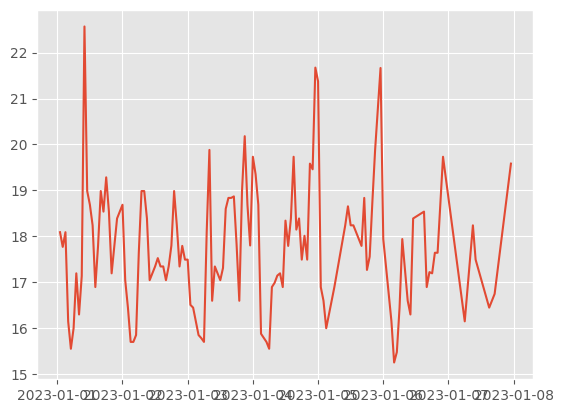

In [106]:
# plot the BS0_df Time and Energy
import matplotlib.pyplot as plt
plt.plot(BS0_df['Time'], BS0_df['Energy'])


In [107]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'BS0_df' is a pandas DataFrame with a 'Time' index and 'Energy' column
# Replace 'BS0_df' with your actual DataFrame

# Convert the 'Time' index to a DateTimeIndex (if it's not already)
BS0_df.index = pd.to_datetime(BS0_df.Time)

# Fit an ARIMA model
model = ARIMA(BS0_df['Energy'], order=(5, 1, 0))  # Example order: ARIMA(5,1,0)
model_fit = model.fit()

# Get a summary of the model
print(model_fit.summary())

# Make predictions
forecast = model_fit.forecast(steps=10)  # Change steps as needed for the number of predictions
print("Forecasted values:", forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Energy   No. Observations:                  132
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -211.595
Date:                Mon, 30 Oct 2023   AIC                            435.190
Time:                        08:18:32   BIC                            452.441
Sample:                             0   HQIC                           442.200
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2843      0.076     -3.724      0.000      -0.434      -0.135
ar.L2         -0.3089      0.085     -3.630      0.000      -0.476      -0.142
ar.L3         -0.2565      0.112     -2.290      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [111]:
print(forecast.index)

RangeIndex(start=132, stop=142, step=1)


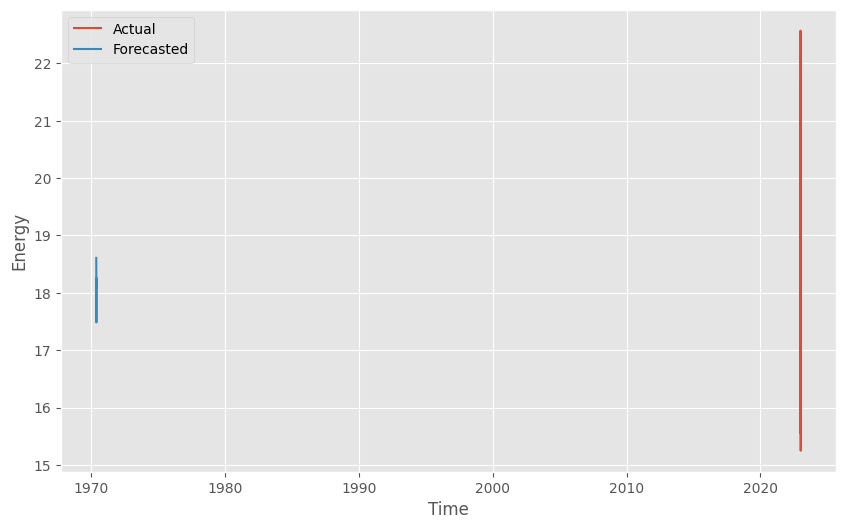

In [110]:
# plot the df with forecasted values in two different colors
plt.figure(figsize=(10, 6))
plt.plot(BS0_df['Time'], BS0_df['Energy'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecasted')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: ignored

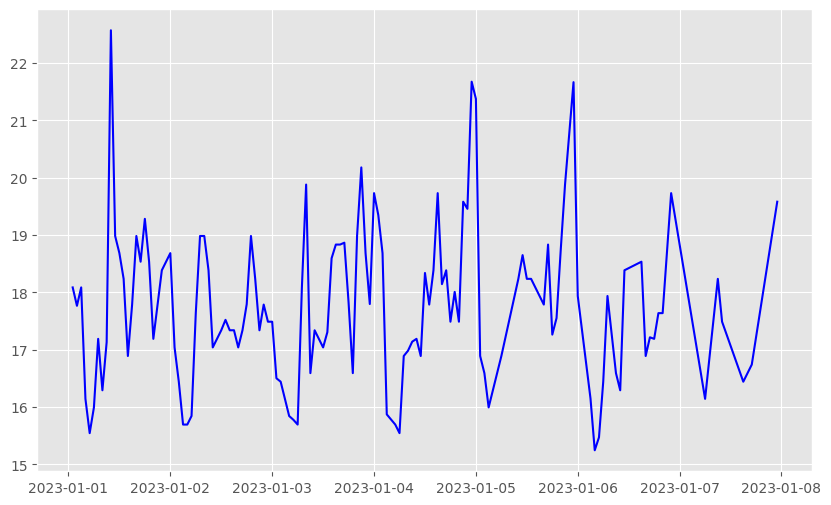

In [112]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# import matplotlib.pyplot as plt

# # Assuming 'BS0_df' is your DataFrame with a 'Time' index and 'Energy' column
# # Replace 'BS0_df' with your actual DataFrame

# # Convert the 'Time' index to a DateTimeIndex (if it's not already)
# BS0_df.index = pd.to_datetime(BS0_df.index)

# # Fit an ARIMA model
# model = ARIMA(BS0_df['Energy'], order=(5, 1, 0))  # Example order: ARIMA(5,1,0)
# model_fit = model.fit()

# # Get the forecasted values
# forecast = model_fit.forecast(steps=10)  # Change steps as needed for the number of predictions

# # Plotting
# plt.figure(figsize=(10, 6))

# # Plot the training data
# plt.plot(BS0_df.index, BS0_df['Energy'], color='blue', label='Training Data')

# # Plot the forecasted values (starting from the last point of the training data)
# forecast_index = pd.date_range(start=BS0_df.index[-1], periods=11, closed='right')[1:]  # Creating index for forecasted values
# plt.plot(forecast_index, forecast, color='red', label='Forecasted Data')

# # Show the plot with legends
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Energy')
# plt.title('ARIMA Forecast vs Training Data')
# plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: ignored

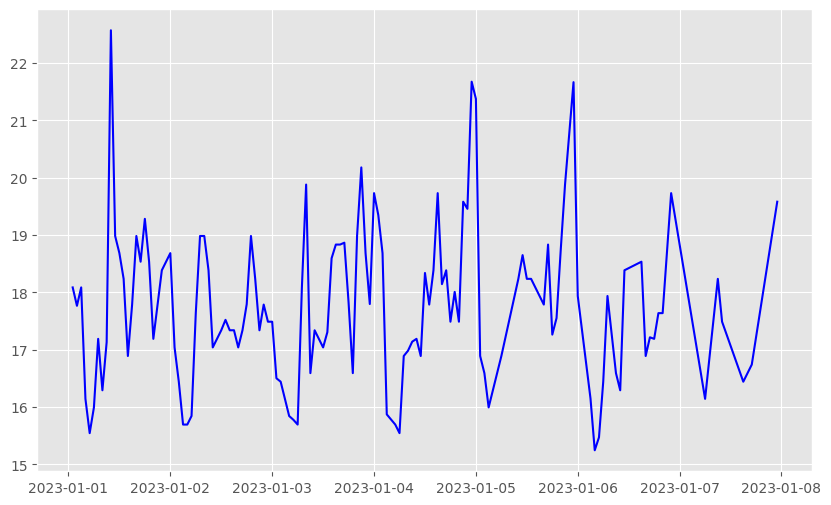

In [113]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# import matplotlib.pyplot as plt

# # Assuming 'BS0_df' is your DataFrame with a 'Time' index and 'Energy' column
# # Replace 'BS0_df' with your actual DataFrame

# # Convert the 'Time' index to a DateTimeIndex (if it's not already)
# BS0_df.index = pd.to_datetime(BS0_df.index)

# # Fit an ARIMA model
# model = ARIMA(BS0_df['Energy'], order=(5, 1, 0))  # Example order: ARIMA(5,1,0)
# model_fit = model.fit()

# # Get the forecasted values
# forecast = model_fit.forecast(steps=10)  # Change steps as needed for the number of predictions

# # Plotting
# plt.figure(figsize=(10, 6))

# # Plot the training data
# plt.plot(BS0_df.index, BS0_df['Energy'], color='blue', label='Training Data')

# # Continue the index from the last date to forecast the future timestamps
# forecast_index = pd.date_range(start=BS0_df.index[-1], periods=10 + 1, closed='right')[1:]

# # Plot the forecasted values (aligned with the forecast_index)
# plt.plot(forecast_index, forecast, color='red', label='Forecasted Data')

# # Show the plot with legends
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Energy')
# plt.title('ARIMA Forecast vs Training Data')
# plt.show()


In [114]:
forecast_index

DatetimeIndex(['2023-01-09 23:00:00', '2023-01-10 23:00:00',
               '2023-01-11 23:00:00', '2023-01-12 23:00:00',
               '2023-01-13 23:00:00', '2023-01-14 23:00:00',
               '2023-01-15 23:00:00', '2023-01-16 23:00:00',
               '2023-01-17 23:00:00'],
              dtype='datetime64[ns]', freq='D')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

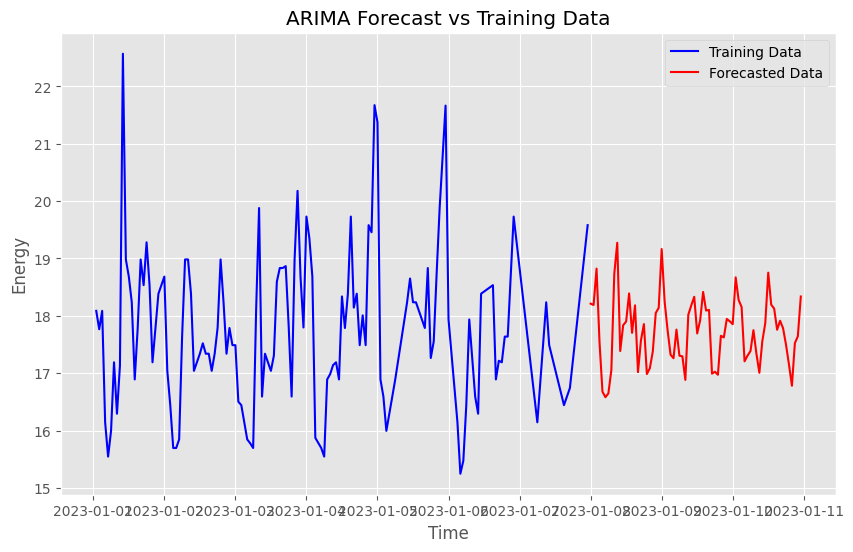

In [152]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming 'BS0_df' is your DataFrame with a 'Time' index and 'Energy' column
# Replace 'BS0_df' with your actual DataFrame

# Convert the 'Time' index to a DateTimeIndex (if it's not already)
BS0_df.index = pd.to_datetime(BS0_df.index)

# Fit an ARIMA model
model = ARIMA(BS0_df['Energy'], order=(24, 1, 12))  # Example order: ARIMA(5,1,0)
model_fit = model.fit()

# Define a new date range for forecasting
new_dates = pd.date_range(start='2023-01-08', periods=72, freq='H')  # Replace with your desired date range and frequency

# Get the forecasted values for the new date range
forecast = model_fit.forecast(steps=len(new_dates))

# Plotting
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(BS0_df.index, BS0_df['Energy'], color='blue', label='Training Data')

# Plot the forecasted values for the new date range
plt.plot(new_dates, forecast, color='red', label='Forecasted Data')

# Show the plot with legends
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('ARIMA Forecast vs Training Data')
plt.show()


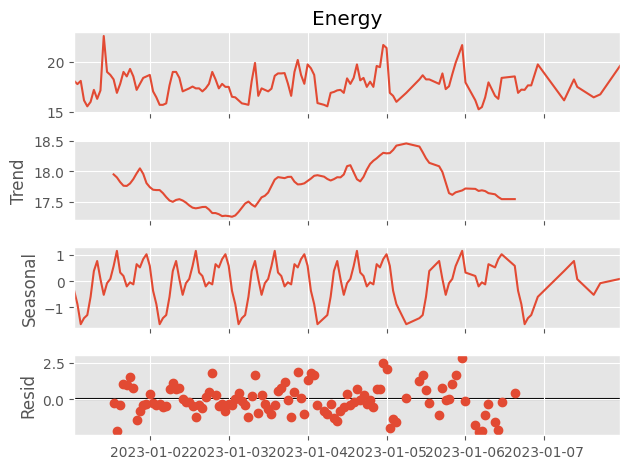

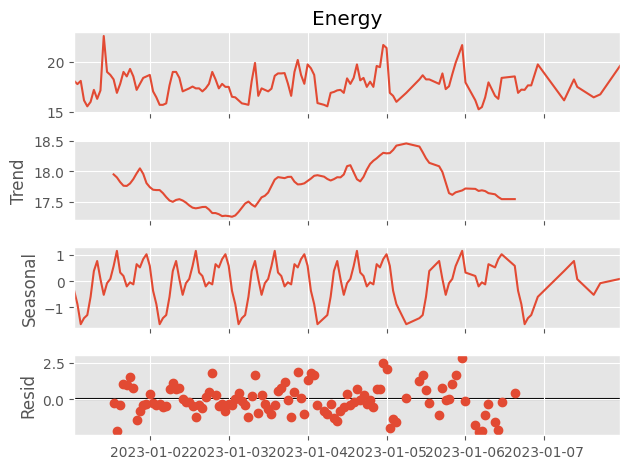

In [150]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(BS0_df['Energy'],model='additive',period=24)
result.plot()

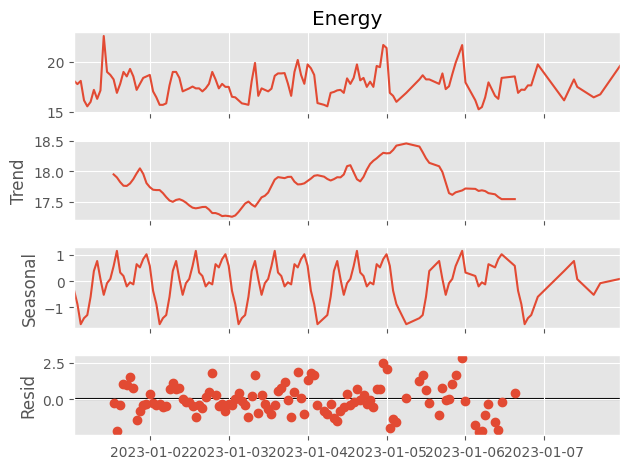

In [129]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# Assuming 'BS0_df' is your DataFrame with a 'Time' index and 'Energy' column
# Replace 'BS0_df' with your actual DataFrame

# Reset index to create a numerical sequence index
# BS0_df_reset = BS0_df.reset_index()

# Use the numerical index instead of the timestamp as the index
result = seasonal_decompose(BS0_df['Energy'], model='additive', period=24)  # You might need to adjust the 'period' based on your data's seasonality

result.plot()
plt.show()


In [135]:
result1 = adfuller(BS0_df['Energy'])
print(result1)

(-6.561199183722522, 8.372856730424512e-09, 1, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 357.71963700331173)


In [145]:
BS0_df.tail(30)

,Time,BS,Energy
Time,,,
2023-01-05 13:00:00,2023-01-05 13:00:00,B_1,18.236173
2023-01-05 16:00:00,2023-01-05 16:00:00,B_1,17.787743
2023-01-05 17:00:00,2023-01-05 17:00:00,B_1,18.834081
2023-01-05 18:00:00,2023-01-05 18:00:00,B_1,17.264336
2023-01-05 19:00:00,2023-01-05 19:00:00,B_1,17.552637
2023-01-05 20:00:00,2023-01-05 20:00:00,B_1,18.755607
2023-01-05 21:00:00,2023-01-05 21:00:00,B_1,19.880419
2023-01-05 23:00:00,2023-01-05 23:00:00,B_1,21.666237
2023-01-06 00:00:00,2023-01-06 00:00:00,B_1,17.937220


In [160]:
BS0_df.head()

,Time,BS,Energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


In [161]:
BS0_df.head()

,Time,BS,Energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


In [162]:
BS0_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    167 non-null    datetime64[ns]
 1   BS      132 non-null    object        
 2   Energy  132 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.0+ KB


In [231]:
split_date1 = '2023-01-03 23:00:00'
split_date2 = '2023-01-04 12:00:00'

train_df = BS0_df[BS0_df['Time']<=pd.to_datetime(split_date1)]
test_df = BS0_df[(BS0_df['Time']<=pd.to_datetime(split_date2))&(BS0_df['Time']>pd.to_datetime(split_date1))]

In [212]:
test_df.head(12)

,Time,BS,Energy
71,2023-01-04 00:00:00,B_0,71.150972
72,2023-01-04 01:00:00,B_0,63.976084
73,2023-01-04 02:00:00,B_0,59.431437
74,2023-01-04 03:00:00,B_0,57.698057
75,2023-01-04 04:00:00,NaN,NaN
76,2023-01-04 05:00:00,B_0,56.837039
77,2023-01-04 06:00:00,B_0,56.801196
78,2023-01-04 07:00:00,B_0,61.883408
79,2023-01-04 08:00:00,B_0,65.171898
80,2023-01-04 09:00:00,B_0,72.096615


In [213]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    71 non-null     datetime64[ns]
 1   BS      71 non-null     object        
 2   Energy  71 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.2+ KB


In [193]:
MLFLOW_TRACKING_URI="https://dagshub.com/samithkavishke/5g-energy-consumption-modeling.mlflow"
MLFLOW_TRACKING_USERNAME="samithkavishke"
MLFLOW_TRACKING_PASSWORD="4469332900401a286a5aac72fc2664e61dbdd80b"


In [194]:
os.environ['MLFLOW_TRACKING_USERNAME'] = MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = MLFLOW_TRACKING_PASSWORD


In [196]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [197]:
import mlflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("TimeSeries")

<Experiment: artifact_location='mlflow-artifacts:/91ea91338e17458dbc119a68e4a43c23', creation_time=1698213974064, experiment_id='1', last_update_time=1698213974064, lifecycle_stage='active', name='TimeSeries', tags={}>

In [217]:
test_df.head(20)

,Time,BS,Energy,Forecasted_Energy
Time,,,,
2023-01-04 00:00:00,2023-01-04 00:00:00,B_0,71.150972,NaN
2023-01-04 01:00:00,2023-01-04 01:00:00,B_0,63.976084,NaN
2023-01-04 02:00:00,2023-01-04 02:00:00,B_0,59.431437,NaN
2023-01-04 03:00:00,2023-01-04 03:00:00,B_0,57.698057,NaN
2023-01-04 04:00:00,2023-01-04 04:00:00,NaN,NaN,NaN
2023-01-04 05:00:00,2023-01-04 05:00:00,B_0,56.837039,NaN
2023-01-04 06:00:00,2023-01-04 06:00:00,B_0,56.801196,NaN
2023-01-04 07:00:00,2023-01-04 07:00:00,B_0,61.883408,NaN
2023-01-04 08:00:00,2023-01-04 08:00:00,B_0,65.171898,NaN


,BS,Energy,Forecasted_Energy
Time,,,
2023-01-04 00:00:00,B_0,71.150972,NaN
2023-01-04 01:00:00,B_0,63.976084,NaN
2023-01-04 02:00:00,B_0,59.431437,NaN
2023-01-04 03:00:00,B_0,57.698057,NaN
2023-01-04 04:00:00,NaN,NaN,NaN
2023-01-04 05:00:00,B_0,56.837039,NaN
2023-01-04 06:00:00,B_0,56.801196,NaN
2023-01-04 07:00:00,B_0,61.883408,NaN
2023-01-04 08:00:00,B_0,65.171898,NaN


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 4.202043100901964
R2 Score: 0.6275328300671584
MAE: 2.9804339659996733


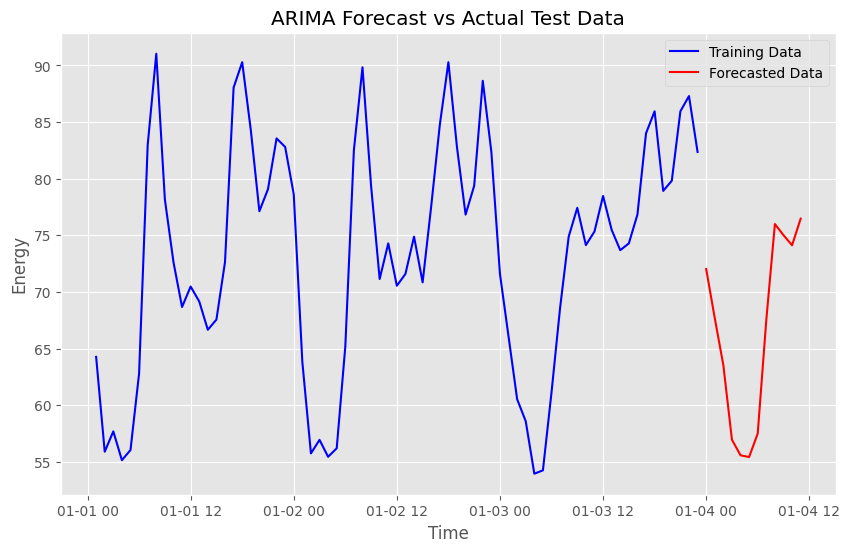

In [241]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming 'train_df' and 'test_df' are your DataFrames with 'Time' index and 'Energy' column
# Replace 'train_df' and 'test_df' with your actual DataFrames

# Convert the 'Time' index of test_df to a DateTimeIndex if it's not already


# Fit an ARIMA model using the train_df
model = ARIMA(train_df['Energy'], order=(24, 1, 0))  # Example order: ARIMA(24,1,0)
model_fit = model.fit()

# Get the forecasted values for the test_df dates
forecast = model_fit.forecast(steps=12)

# Create a new column 'Forecasted_Energy' in test_df and set the values as forecast
test_df['Forecasted_Energy'] = forecast

# Drop rows with NaN values in 'Energy' and 'Forecasted_Energy' columns in test_df
test_df.dropna(subset=['Energy', 'Forecasted_Energy'], inplace=True)

# Calculate RMSE, R2 score, and MAE after removing NaN values
rmse = mean_squared_error(test_df['Energy'], test_df['Forecasted_Energy'], squared=False)
r2 = r2_score(test_df['Energy'], test_df['Forecasted_Energy'])
mae = mean_absolute_error(test_df['Energy'], test_df['Forecasted_Energy'])

# Output the calculated metrics
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")
new_dates = pd.date_range(start='2023-01-04', periods=12, freq='H')  # Replace with your desired date range and frequency

plot_df = test_df.copy()
plot_df.index = pd.to_datetime(plot_df.Time)
plot_df.drop(columns="Time",axis=1,inplace=True)
plot_df.head(13)

plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train_df.Time, train_df['Energy'], color='blue', label='Training Data')

# Plot the forecasted values for the new date range
plt.plot(new_dates, forecast, color='red', label='Forecasted Data')

# Show the plot with legends
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('ARIMA Forecast vs Actual Test Data')
plt.show()

params = {'p':24,'d':1,'q': 0}
with mlflow.start_run():
  mlflow.log_params(params)
  # for key, value in params.items():
  #     mlflow.log_param(key, value)
  mlflow.log_metric("MAE", mae)
  mlflow.log_metric("RMSE", rmse)
  mlflow.log_metric("R2", r2)
  # mlflow.log_artifacts(model_fit)
  # mlflow.log_artifact('dataset_statistics.csv')
mlflow.end_run()

In [236]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    71 non-null     datetime64[ns]
 1   BS      71 non-null     object        
 2   Energy  71 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.2+ KB


In [222]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming 'train_df' and 'test_df' are your DataFrames with 'Time' index and 'Energy' column
# Replace 'train_df' and 'test_df' with your actual DataFrames

# Convert the 'Time' index of test_df to a DateTimeIndex if it's not already

# Fit an ARIMA model using the train_df
model = ARIMA(train_df['Energy'], order=(24, 1, 0))  # Example order: ARIMA(24,1,0)
model_fit = model.fit()

# Get the forecasted values for the test_df dates
forecast = model_fit.forecast(steps=12)

# Create a new column 'Forecasted_Energy' in test_df and set the values as forecast
test_df['Forecasted_Energy'] = forecast

# Print the updated test_df with 'Forecasted_Energy' column
print(test_df)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                      BS     Energy  Forecasted_Energy
Time                                                  
2023-01-04 00:00:00  B_0  71.150972                NaN
2023-01-04 01:00:00  B_0  63.976084                NaN
2023-01-04 02:00:00  B_0  59.431437                NaN
2023-01-04 03:00:00  B_0  57.698057                NaN
2023-01-04 04:00:00  NaN        NaN                NaN
2023-01-04 05:00:00  B_0  56.837039                NaN
2023-01-04 06:00:00  B_0  56.801196                NaN
2023-01-04 07:00:00  B_0  61.883408                NaN
2023-01-04 08:00:00  B_0  65.171898                NaN
2023-01-04 09:00:00  B_0  72.096615                NaN
2023-01-04 10:00:00  B_0  72.795217                NaN
2023-01-04 11:00:00  B_0  76.980568                NaN
2023-01-04 12:00:00  B_0  78.026906                NaN


In [223]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train_df' and 'test_df' are your DataFrames with 'Time' index and 'Energy' column
# Replace 'train_df' and 'test_df' with your actual DataFrames

# Convert the 'Time' index of test_df to a DateTimeIndex if it's not already

# Fit an ARIMA model using the train_df
model = ARIMA(train_df['Energy'], order=(24, 1, 0))  # Example order: ARIMA(24,1,0)
model_fit = model.fit()

# Get the forecasted values for the test_df dates
forecast = model_fit.forecast(steps=12)

# Create a new column 'Forecasted_Energy' in test_df and set the values as forecast
test_df['Forecasted_Energy'] = pd.Series(forecast, index=test_df.index[-12:])

# Print the updated test_df with 'Forecasted_Energy' column
print(test_df)


                      BS     Energy  Forecasted_Energy
Time                                                  
2023-01-04 00:00:00  B_0  71.150972                NaN
2023-01-04 01:00:00  B_0  63.976084                NaN
2023-01-04 02:00:00  B_0  59.431437                NaN
2023-01-04 03:00:00  B_0  57.698057                NaN
2023-01-04 04:00:00  NaN        NaN                NaN
2023-01-04 05:00:00  B_0  56.837039                NaN
2023-01-04 06:00:00  B_0  56.801196                NaN
2023-01-04 07:00:00  B_0  61.883408                NaN
2023-01-04 08:00:00  B_0  65.171898                NaN
2023-01-04 09:00:00  B_0  72.096615                NaN
2023-01-04 10:00:00  B_0  72.795217                NaN
2023-01-04 11:00:00  B_0  76.980568                NaN
2023-01-04 12:00:00  B_0  78.026906                NaN


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [224]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train_df' and 'test_df' are your DataFrames with 'Time' index and 'Energy' column
# Replace 'train_df' and 'test_df' with your actual DataFrames

# Fit an ARIMA model using the train_df
model = ARIMA(train_df['Energy'], order=(24, 1, 0))  # Example order: ARIMA(24,1,0)
model_fit = model.fit()

# Get the forecasted values for the test_df dates
forecast = model_fit.forecast(steps=len(test_df))  # Forecast for the entire test_df length

# Create a new column 'Forecasted_Energy' in test_df and set the values as forecast
test_df['Forecasted_Energy'] = forecast

# Print the updated test_df with 'Forecasted_Energy' column
print(test_df)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                      BS     Energy  Forecasted_Energy
Time                                                  
2023-01-04 00:00:00  B_0  71.150972                NaN
2023-01-04 01:00:00  B_0  63.976084                NaN
2023-01-04 02:00:00  B_0  59.431437                NaN
2023-01-04 03:00:00  B_0  57.698057                NaN
2023-01-04 04:00:00  NaN        NaN                NaN
2023-01-04 05:00:00  B_0  56.837039                NaN
2023-01-04 06:00:00  B_0  56.801196                NaN
2023-01-04 07:00:00  B_0  61.883408                NaN
2023-01-04 08:00:00  B_0  65.171898                NaN
2023-01-04 09:00:00  B_0  72.096615                NaN
2023-01-04 10:00:00  B_0  72.795217                NaN
2023-01-04 11:00:00  B_0  76.980568                NaN
2023-01-04 12:00:00  B_0  78.026906                NaN


In [229]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train_df' and 'test_df' are your DataFrames with 'Time' index and 'Energy' column
# Replace 'train_df' and 'test_df' with your actual DataFrames

# Fit an ARIMA model using the train_df
model = ARIMA(train_df['Energy'], order=(24, 1, 0))  # Example order: ARIMA(24,1,0)
model_fit = model.fit()

# Get the forecasted values for the test_df dates
forecast_values = model_fit.forecast(steps=len(test_df))  # Forecast for the entire test_df length

# Create a DataFrame for the forecasted values with proper index
forecast_df = pd.DataFrame(forecast_values, columns=['Forecasted_Energy'], index=test_df.index)

# Merge the forecast DataFrame with the test_df based on the common index
test_df = test_df.merge(forecast_df, how='left', left_index=True, right_index=True)

# Print the updated test_df with 'Forecasted_Energy' column
print(test_df)


                      BS     Energy Forecasted_Energy_x Forecasted_Energy_x  \
Time                                                                          
2023-01-04 00:00:00  B_0  71.150972                 NaN                 NaN   
2023-01-04 01:00:00  B_0  63.976084                 NaN                 NaN   
2023-01-04 02:00:00  B_0  59.431437                 NaN                 NaN   
2023-01-04 03:00:00  B_0  57.698057                 NaN                 NaN   
2023-01-04 04:00:00  NaN        NaN                 NaN                 NaN   
2023-01-04 05:00:00  B_0  56.837039                 NaN                 NaN   
2023-01-04 06:00:00  B_0  56.801196                 NaN                 NaN   
2023-01-04 07:00:00  B_0  61.883408                 NaN                 NaN   
2023-01-04 08:00:00  B_0  65.171898                 NaN                 NaN   
2023-01-04 09:00:00  B_0  72.096615                 NaN                 NaN   
2023-01-04 10:00:00  B_0  72.795217                 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [230]:
forecast_values

71    72.031140
72    67.699664
73    63.539513
74    56.968458
75    55.586751
76    55.435222
77    57.509181
78    67.535104
79    75.998826
80    75.016286
81    74.126104
82    76.476201
83    79.510707
Name: predicted_mean, dtype: float64

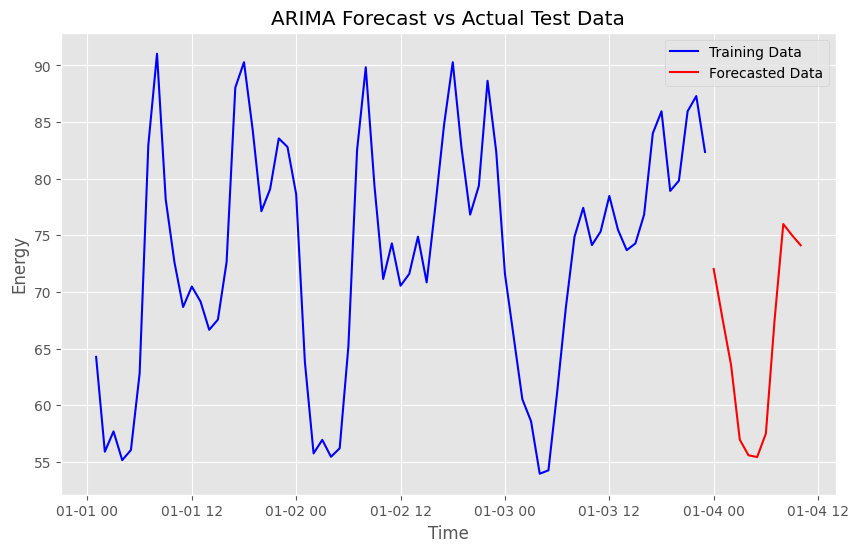

In [199]:
new_dates = pd.date_range(start='2023-01-04', periods=144, freq='H')  # Replace with your desired date range and frequency
forecast = model_fit.forecast(steps=144)
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train_df.index, train_df['Energy'], color='blue', label='Training Data')

# Plot the forecasted values for the new date range
plt.plot(new_dates, forecast, color='red', label='Forecasted Data')

# Show the plot with legends
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('ARIMA Forecast vs Actual Test Data')
plt.show()
